In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
# download dataset from kaggle
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:51<00:00, 22.9MB/s]
100% 1.06G/1.06G [00:51<00:00, 22.1MB/s]


In [ ]:
# unzipping the file
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [ ]:
# Generators - divide the data into batches (helpful in processing large datasets)
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256)
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256, 256)
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [ ]:
# Normalize data --> process takes the image and label as input --> image is converted to 32bit floating point tensor & /255
def process(image, label):
  image = tf.cast(image/255. ,tf.float32)
  return image, label

# map fn --> apply the fn process to each element in dataset
train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# CNN model

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,297 (56.64 MB)

 Trainable params: 14,847,297 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer = "Adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit (train_ds, epochs = 10, validation_data = test_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 95ms/step - accuracy: 0.5873 - loss: 0.6986 - val_accuracy: 0.7058 - val_loss: 0.5865
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 73ms/step - accuracy: 0.7244 - loss: 0.5450 - val_accuracy: 0.7740 - val_loss: 0.4782
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 75ms/step - accuracy: 0.7980 - loss: 0.4250 - val_accuracy: 0.7854 - val_loss: 0.4824
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 79ms/step - accuracy: 0.8775 - loss: 0.2877 - val_accuracy: 0.7542 - val_loss: 0.7860
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.9445 - loss: 0.1454 - val_accuracy: 0.7498 - val_loss: 0.9121
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.9673 - loss: 0.0908 - val_accuracy: 0.7590 - val_loss: 1.1611
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 79ms/step - accuracy: 0.9784 - loss: 0.0707 - val_accuracy: 0.7560 - val_loss: 1.3591
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 72ms/step - accuracy: 0.9846 - loss: 0.0423 - 

In [ ]:
model.evaluate(train_ds, batch_size=32)

625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9605 - loss: 0.1336


[0.13183441758155823, 0.9609500169754028]

In [ ]:
model.evaluate(test_ds, batch_size = 32)

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7529 - loss: 1.5638


[1.5962858200073242, 0.7490000128746033]

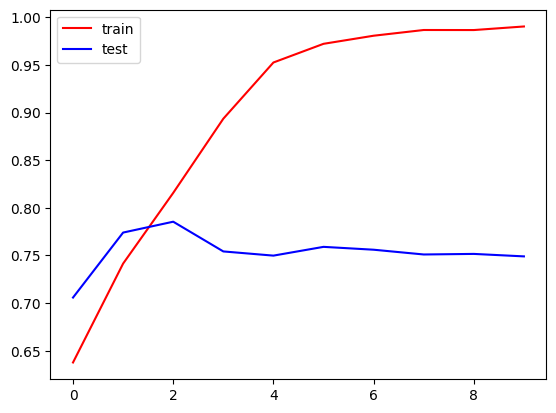

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='r', label = "train")
plt.plot(history.history['val_accuracy'], color='b', label = "test")
plt.legend()
plt.show()

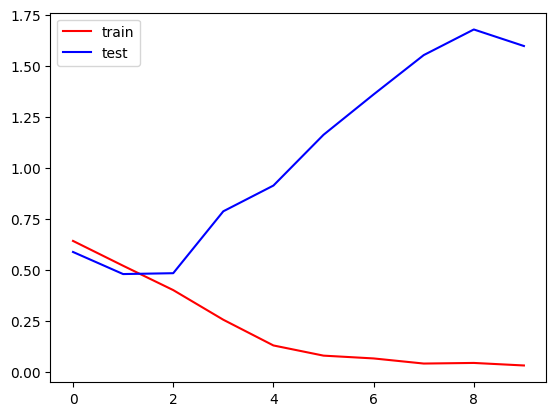

In [ ]:
plt.plot(history.history['loss'], color='r', label = "train")
plt.plot(history.history['val_loss'], color='b', label = "test")
plt.legend()
plt.show()

Overfitting of data ---  model shows high accuracy or low error on the training set but significantly lower accuracy or higher error on the test/validation set.

gap between both shows overfitting

how to overcome?

use more data

data agumentation

batch normalization, dropout



In [ ]:

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(
    optimizer = "Adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [ ]:
history_1 = model.fit (train_ds, epochs = 10, validation_data = test_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.5695 - loss: 1.6224 - val_accuracy: 0.6276 - val_loss: 0.6261
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 101ms/step - accuracy: 0.6856 - loss: 0.6052 - val_accuracy: 0.7108 - val_loss: 0.5538
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 86ms/step - accuracy: 0.7496 - loss: 0.5093 - val_accuracy: 0.7354 - val_loss: 0.5387
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - accuracy: 0.7985 - loss: 0.4387 - val_accuracy: 0.8034 - val_loss: 0.4401
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.8324 - loss: 0.3759 - val_accuracy: 0.7964 - val_loss: 0.4630
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.8744 - loss: 0.3003 - val_accuracy: 0.6782 - val_loss: 1.1586
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.9148 - loss: 0.2128 - val_accuracy: 0.8310 - val_loss: 0.4795
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.9444 - loss: 0.1442 -

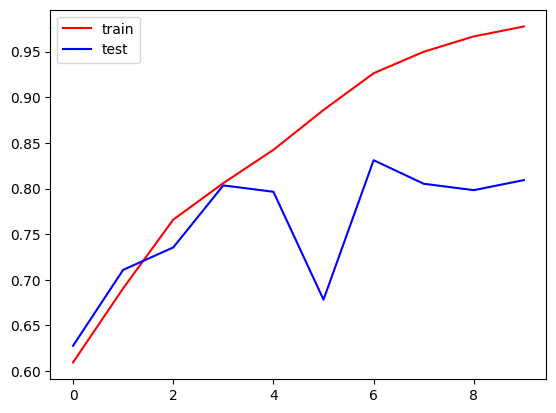

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_1.history['accuracy'], color='r', label = "train")
plt.plot(history_1.history['val_accuracy'], color='b', label = "test")
plt.legend()
plt.show()

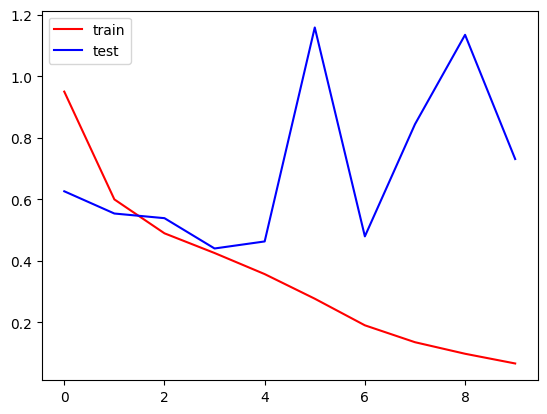

In [ ]:
plt.plot(history_1.history['loss'], color='r', label = "train")
plt.plot(history_1.history['val_loss'], color='b', label = "test")
plt.legend()
plt.show()

In [ ]:
import cv2

In [ ]:
test_img = cv2.imread("/content/Dog.jpg")

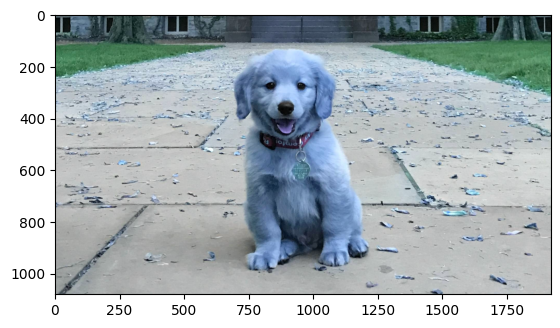

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

(1080, 1920, 3)

In [ ]:
test_img = cv2.resize(test_img, (256,256))

In [ ]:
test_input = test_img.reshape ((1,256,256,3))

In [ ]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


array([[1.]], dtype=float32)

In [ ]:
test_img1 = cv2.imread("/content/cat.10.jpg")

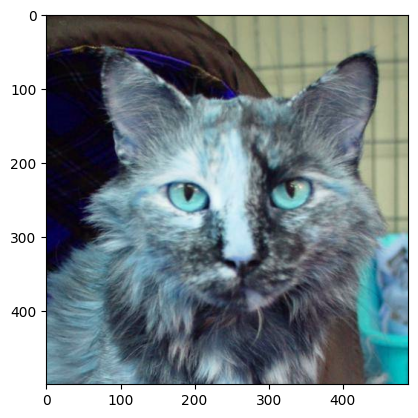

In [ ]:
plt.imshow(test_img1)

In [ ]:
test_img1.shape

(499, 489, 3)

In [ ]:
test_img1 = cv2.resize(test_img1, (256,256))

In [ ]:
test_input1= test_img1.reshape ((1,256,256,3))

In [ ]:
model.predict(test_input1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[1.]], dtype=float32)